In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # to edit text in Illustrator

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import sys
import scipy
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import plotly.express as px
from tqdm import tqdm
from scipy.stats import ranksums
from adjustText import adjust_text
from datetime import datetime

paper_path = os.path.dirname(os.getcwd())#"/mnt/x/Common/Lab_Papers/shedding_potential/"
print(paper_path)
figure_path = paper_path+ "/fig3/"
harnik_data_path = paper_path + "/external_datasets/harnik_data/"
utils_path = paper_path + "/utils/"

os.chdir(utils_path)
print(os.getcwd())
import shed_funcs

LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = utils_path+'/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

/Users/talbarkai/Data/shedding_potential/zenodo
/Users/talbarkai/Data/shedding_potential/zenodo/utils


## Load residuals

In [2]:
duodenum_resids = pd.read_csv(figure_path+"/duodenum_residuals.csv")
duodenum_resids.index = duodenum_resids.gene_name
duodenum_resids.head()

gene_name    biopsy      wash  log_biopsy  log_wash  residual
gene_name                                                              
A1CF           A1CF  0.000240  0.000007   -3.602765 -4.762239 -0.711925
AADAC         AADAC  0.000151  0.000049   -3.792142 -4.228758 -0.071671
AAK1           AAK1  0.000071  0.000088   -4.089217 -4.007854  0.316725
ABAT           ABAT  0.000094  0.000035   -3.982075 -4.349615 -0.085443
ABCA5         ABCA5  0.000065  0.000050   -4.125870 -4.220014  0.125231

In [3]:
def load_yotam_visium_sample(folder_path, plot_figure = False, title=None, fig_size=(3,3), save_figure=False, save_path="", spot_size=None):
    df = sc.read_csv(folder_path + "counts.csv").T
    genes = pd.read_csv(folder_path + "gene_name.csv", header=None)
    df.var.index = genes[0]

    # add coordinates
    coor = pd.read_csv(folder_path + "coor.csv",header=None)
    coor.columns = ['x', 'y']
    coor.index = df.obs_names
    df.obs[['x','y']] = coor

    # add villus bins
    villus_bins = pd.read_csv(folder_path + "villus_bin.csv",header=None)
    villus_bins.columns=["villus_bin"]
    villus_bins.index = df.obs_names
    df.obs[['villus_bin']] = villus_bins

    # add labels
    villus_bin_lbl = pd.read_csv(folder_path + "villus_bin_lbl.csv", header=None)
    villus_bin_lbl_dict = villus_bin_lbl.T[0].to_dict()
    villus_bin_lbl_dict = {k - 2: v for k, v in villus_bin_lbl_dict.items()}
    df.obs.villus_bin = df.obs.villus_bin.map(villus_bin_lbl_dict).astype('category')
    df.obs.villus_bin = df.obs.villus_bin.cat.reorder_categories(['Crypt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'MusMucosa', 'SubMucosa'])

    if plot_figure:
        fig, ax = plt.subplots(figsize=fig_size, dpi=300)
        sns.scatterplot(data=df.obs, x='x', y='y', hue='villus_bin', alpha=0.6, s=spot_size, edgecolor=None, linewidth=0)
        
        # hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
        # hide x and y labels
        ax.set_xlabel('')
        ax.set_ylabel('')

        # hide x and y ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # legend to the bottom right
        plt.legend(loc='lower right', bbox_to_anchor=(1.05, 0.0), title='Villus bins')

        # add scale bar to the bottom right
        distances = pdist(df.obs[['x','y']])
        distances = squareform(distances)
        distances = pd.DataFrame(distances, index=df.obs_names, columns=df.obs_names)
        distances = distances.iloc[0:2]
        distances = distances[(distances < 400) * (distances > 0)]
        distances = distances[(distances < 400) * (distances > 0)].values.flatten()
        distances = distances[~np.isnan(distances)]

        # [n,bins,patches] = plt.hist(distances.values.flatten(), bins=100)
        hist, bin_edges = np.histogram(distances, bins=100)
        if hist[0] == 12:
            size_100um = bin_edges[0]
            print("Size 100um: "+str(size_100um))
            df.uns['size_100um'] = size_100um
            df.uns['size_100um_origin'] = 'calc'
        else:
            print("Using default")
            size_100um = 23.32125500223971
            df.uns['size_100um'] = size_100um
            df.uns['size_100um_origin'] = 'Based on P1'
            
        scalebar_x = df.obs.x.min() + 5
        scalebar_y = df.obs.y.min() + 5
        plt.plot([scalebar_x, scalebar_x + size_100um*5], [scalebar_y, scalebar_y], color='black', lw=2, solid_capstyle='butt')

        if title is not None:
            plt.title(title)
        else:
            plt.title(folder_path)
        plt.show()
        if save_figure:
            fig.savefig(save_path, bbox_inches='tight')

    return df

In [4]:
figure_path

'/Users/talbarkai/Data/shedding_potential/zenodo/fig3/'

['P5', 'P10', 'P11', 'P9', 'P8', 'P1', 'P13', 'P12']
Size 100um: 24.495804897967314


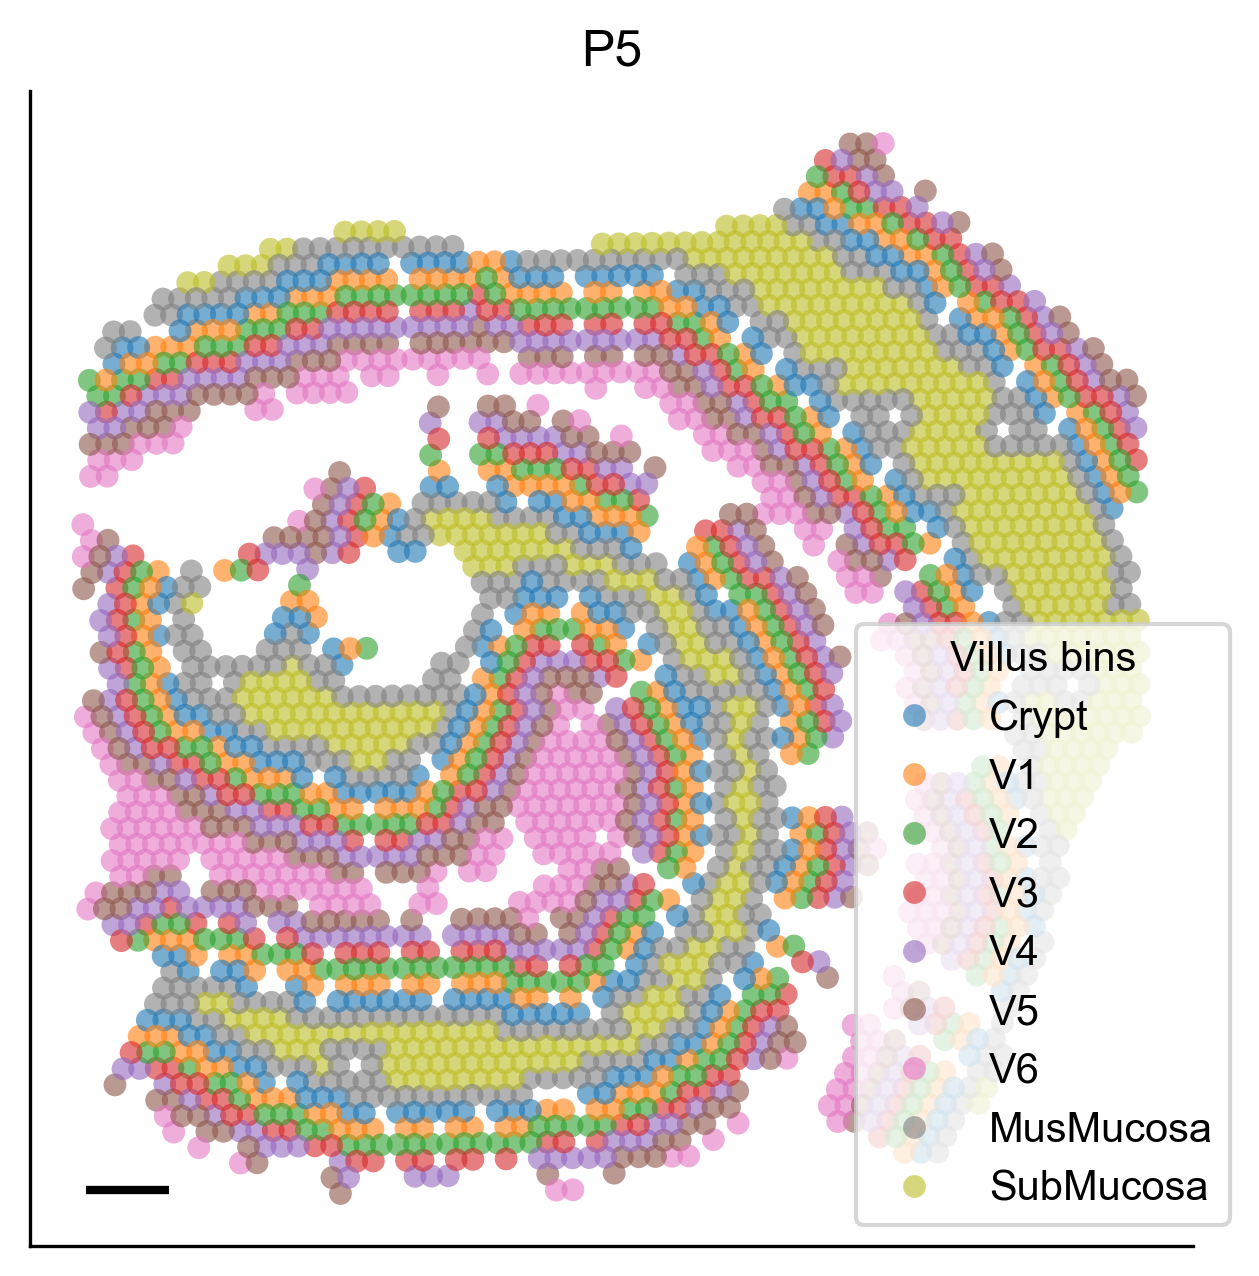

Size 100um: 25.217090374258575


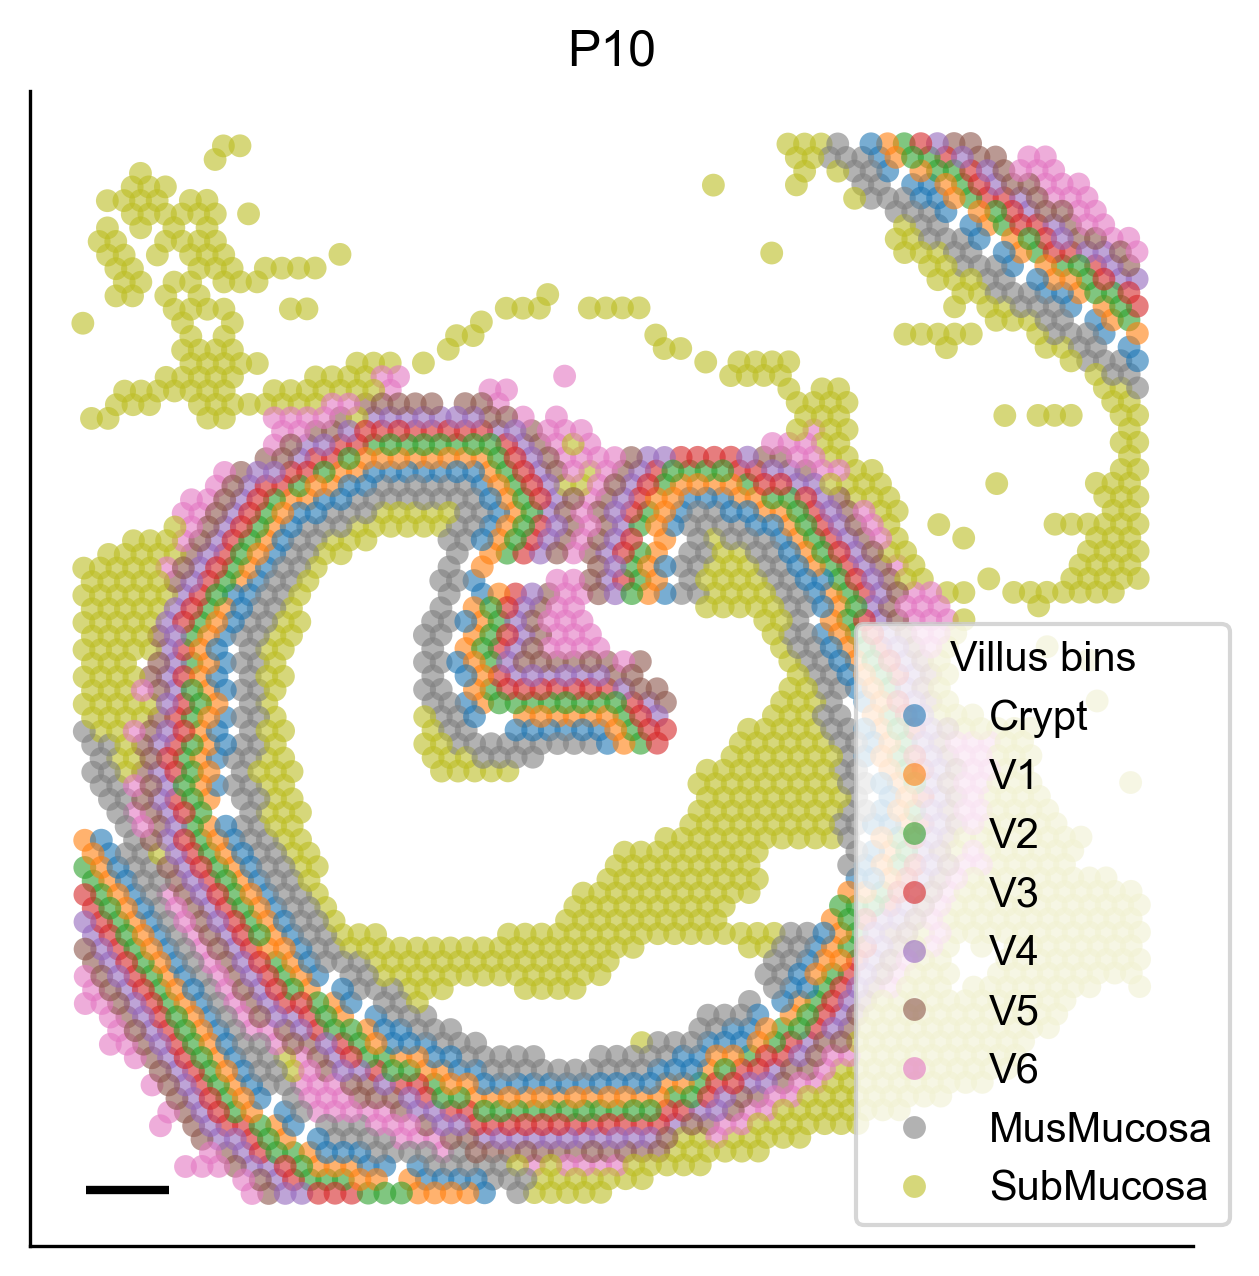

Using default


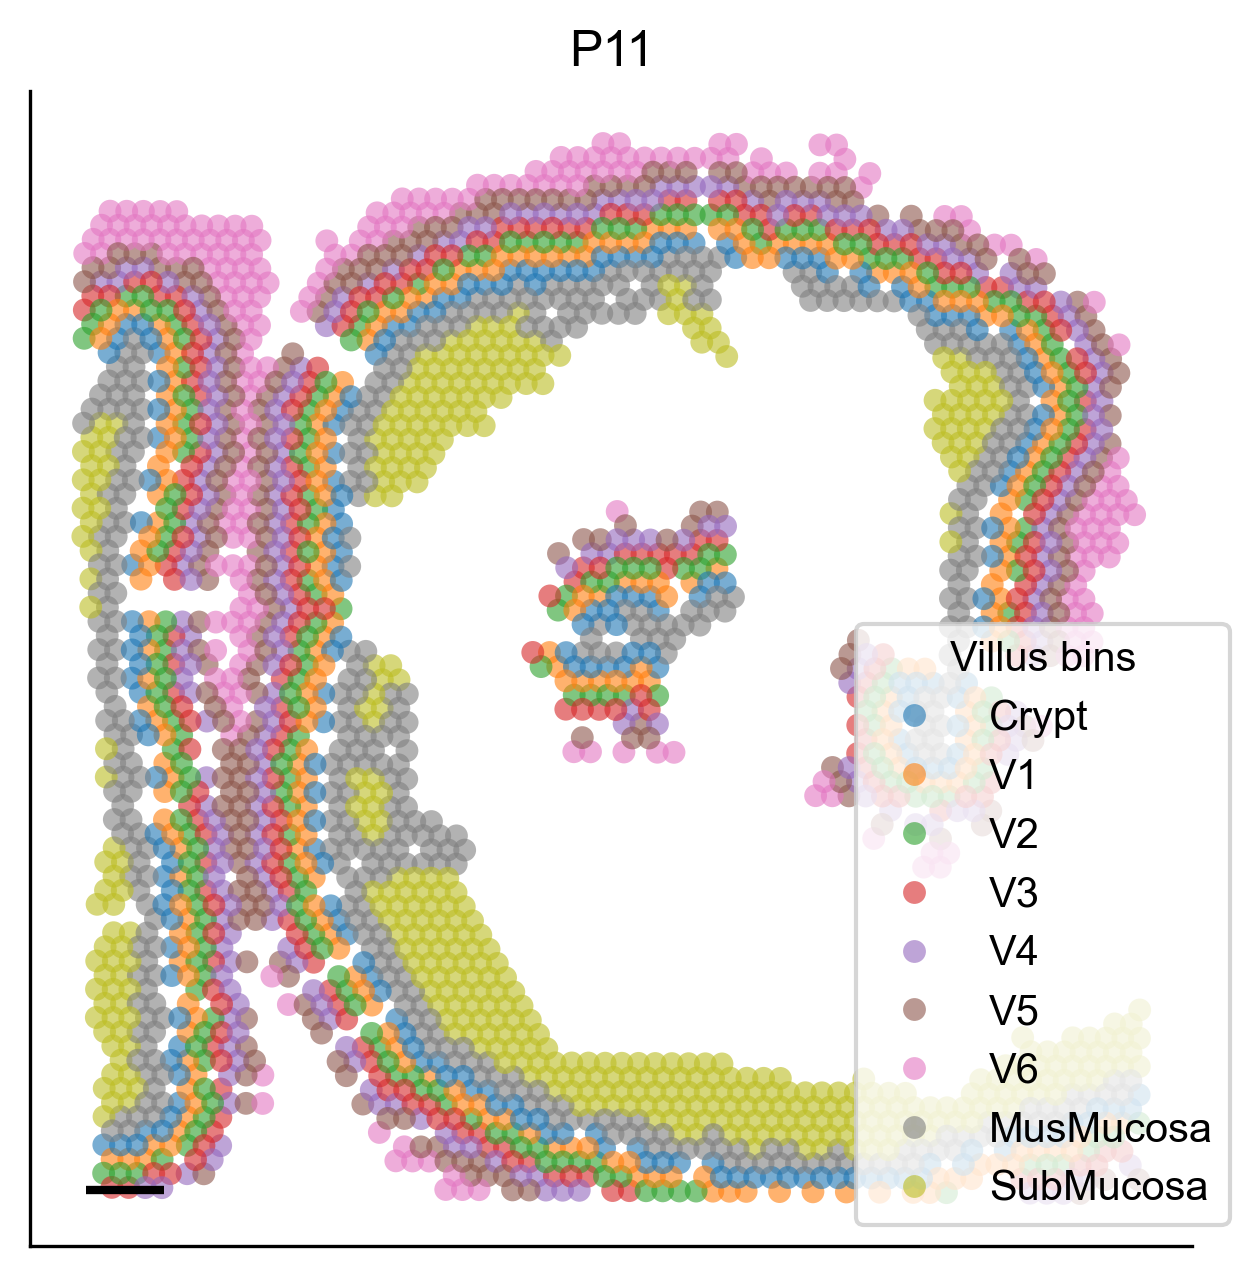

Size 100um: 24.691217127890717


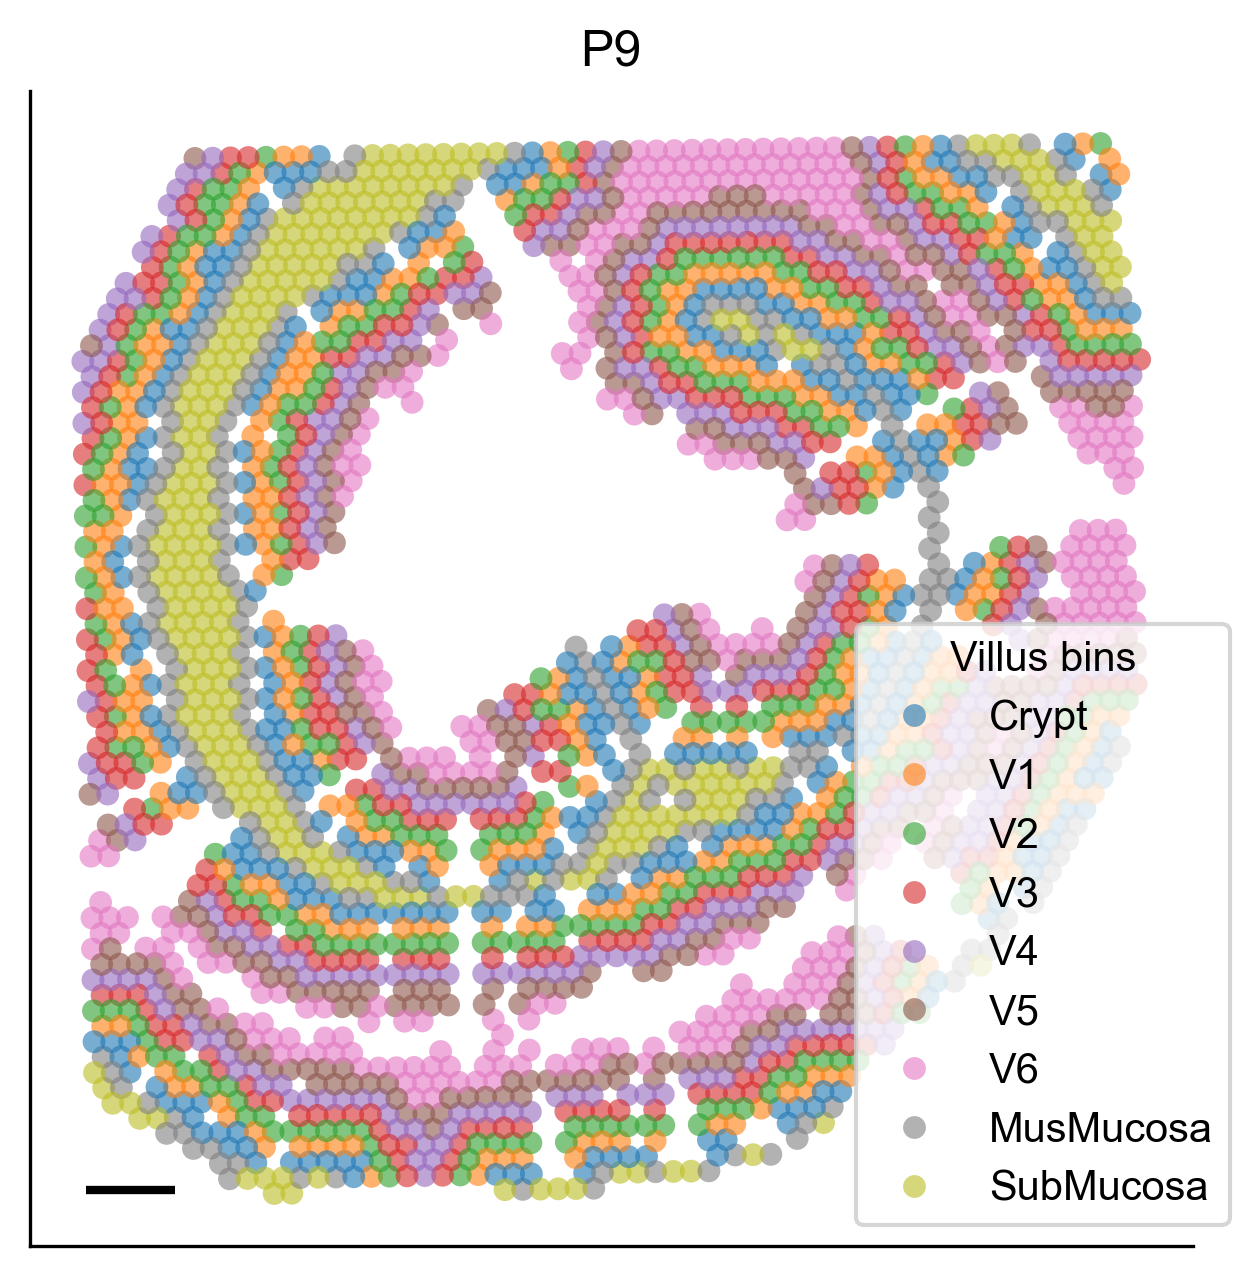

Size 100um: 24.505074318229525


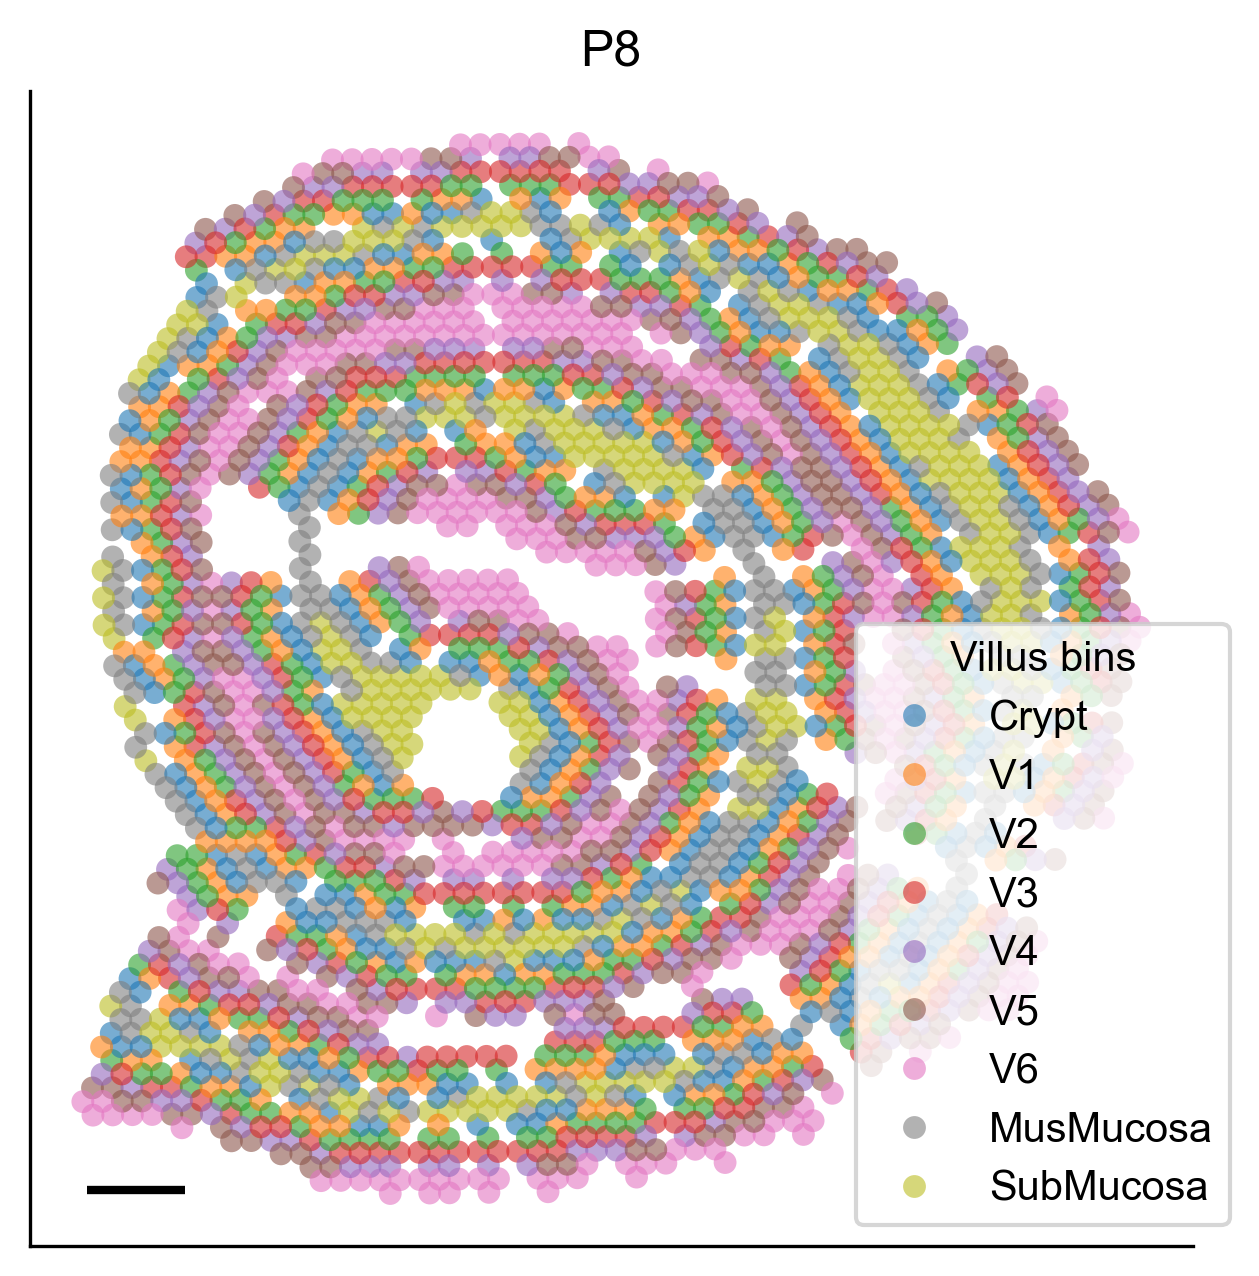

Size 100um: 23.32125500223971


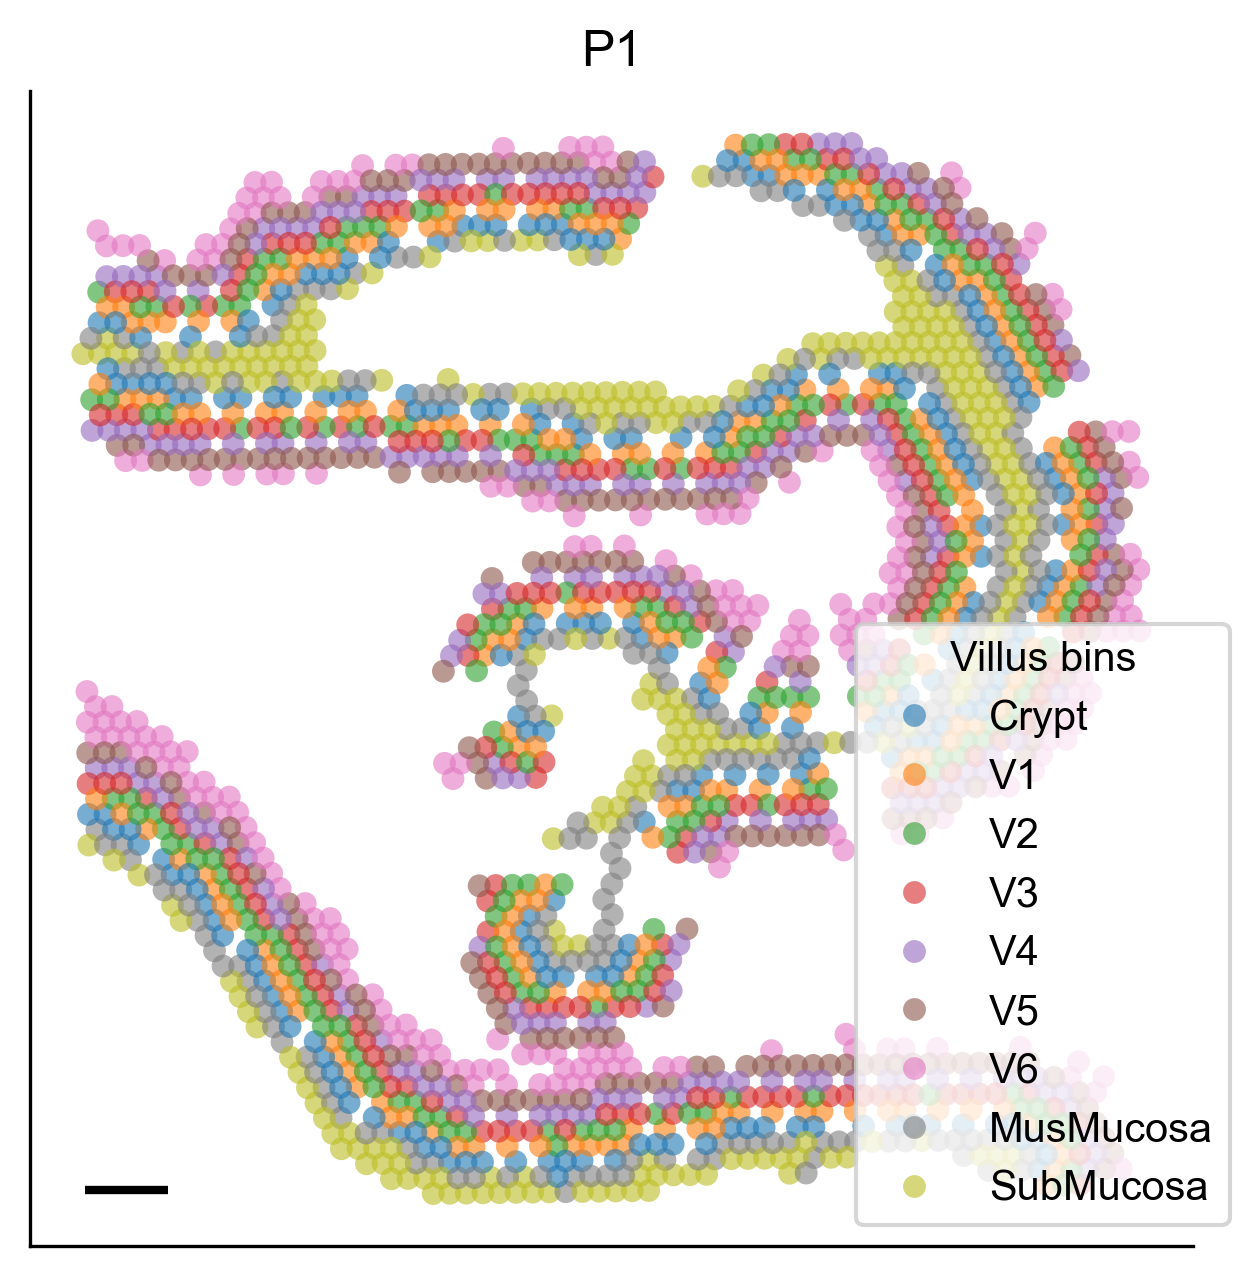

Using default


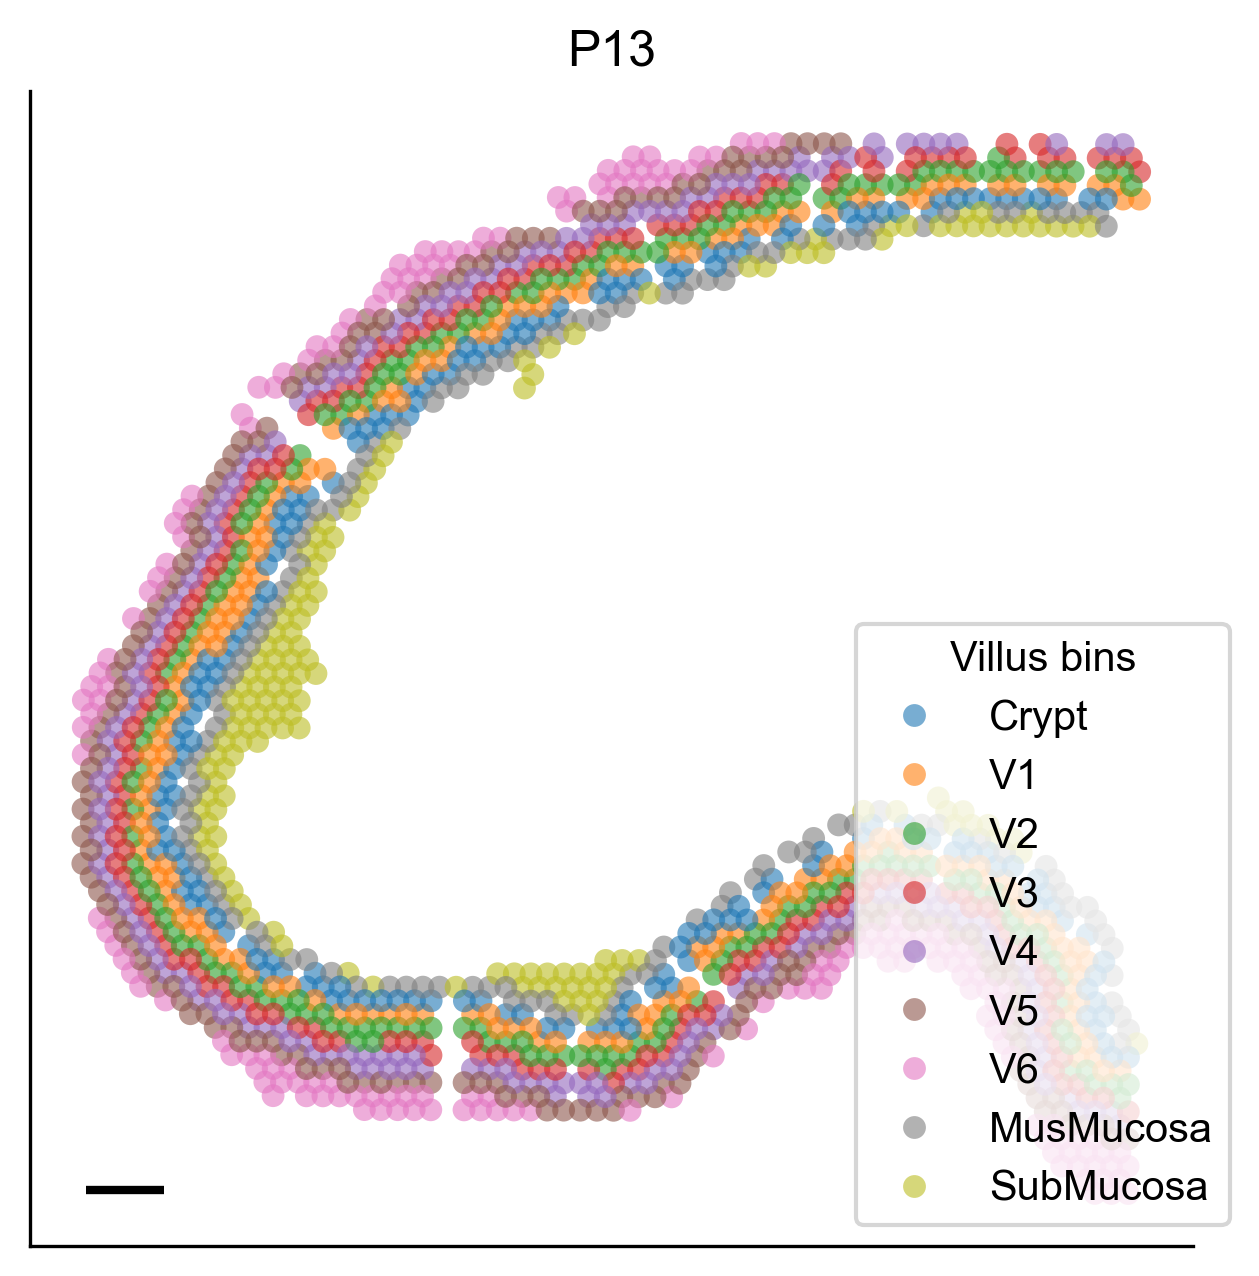

Using default


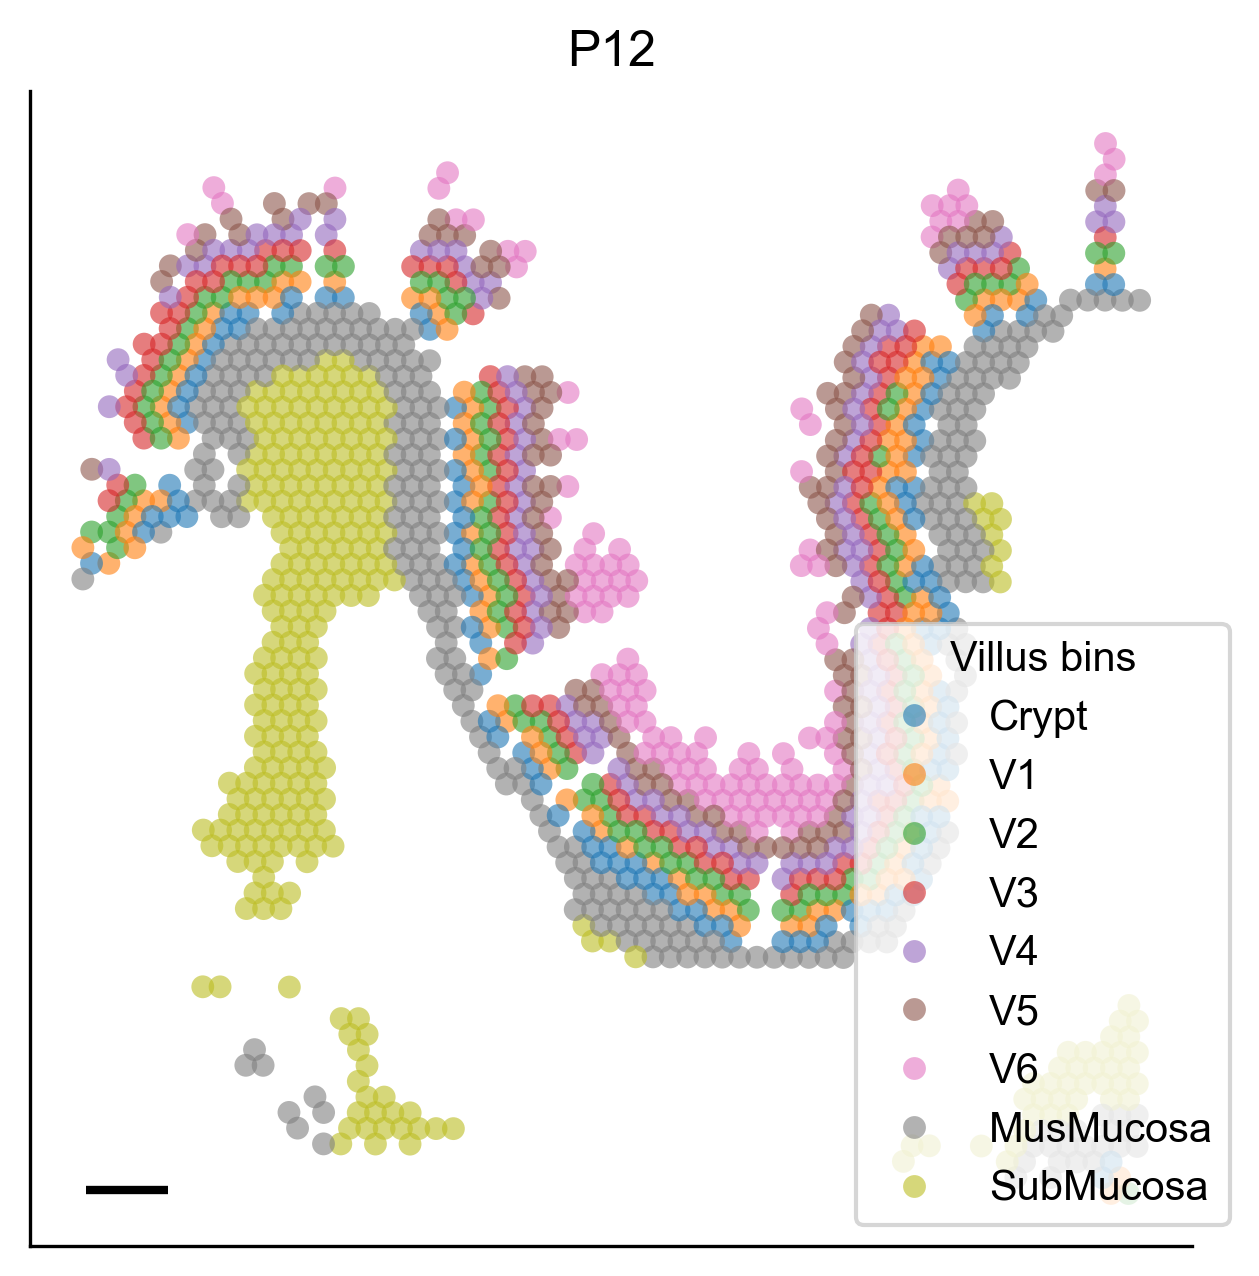

In [5]:
# yotams_folder = figure_path+"/harnik_data/"
subfolders = [f.name for f in os.scandir(harnik_data_path) if f.is_dir()]
save_to = figure_path + "/harnik_data/"
if not os.path.exists(save_to):
    os.makedirs(save_to)
print(subfolders)
yotam_visium = dict()
for subfolder in subfolders:
    yotam_visium[subfolder] = load_yotam_visium_sample(harnik_data_path+"/"+subfolder+"/", spot_size=30,
                                                       plot_figure=True, title=subfolder, fig_size=(5,5),
                                                       save_figure=True, save_path=save_to+"Visium"+subfolder+".pdf")

In [6]:
yotam_visium_full = dict()
biomart_tbl = pd.read_csv(utils_path+'/Human_GRch38_91_ensemblBioMart_ref.csv')
biomart_tbl = biomart_tbl[biomart_tbl['gene_biotype'] == "protein_coding"]

In [7]:
UMI_THRESH = 1000

for key in tqdm(yotam_visium.keys()):
    tmp = yotam_visium[key].copy()
    tmp.var.index.name = None
    tmp.var_names_make_unique()
    
    tmp.obs['sum_of_umis'] = tmp.X.sum(axis=1)# calc sum of UMIs for each obs

    # filter out cells with less than 1000 UMIs
    print(tmp.shape)
    tmp = tmp[tmp.obs['sum_of_umis'] > UMI_THRESH, :]
    print(tmp.shape)

    # save a copy that contains all genes
    yotam_visium_full[key] = tmp.copy()
    yotam_visium_full[key].layers['counts'] = yotam_visium_full[key].X.copy()# save counts in .layers
    sc.pp.normalize_total(yotam_visium_full[key], target_sum=1, inplace=True, exclude_highly_expressed=True, max_fraction=0.05)
    yotam_visium_full[key].layers['mat_norm'] = yotam_visium_full[key].X.copy()
    # keep only protein coding genes
    yotam_visium_full[key] = yotam_visium_full[key][:,yotam_visium_full[key].var_names.isin(biomart_tbl['external_gene_name'])].copy()


    tmp = tmp[:,np.intersect1d(tmp.var_names, duodenum_resids.index)]

    tmp.layers['counts'] = tmp.X.copy()# save counts in .layers
    # calc mat_norm
    sc.pp.normalize_total(tmp, target_sum=1, inplace=True, exclude_highly_expressed=True, max_fraction=0.05)
    tmp.layers['mat_norm'] = tmp.X.copy()

    duodenum_resids.index = duodenum_resids['gene_name']
    duodenum_resids = duodenum_resids.loc[tmp.var_names]

    tmp.obs['shedding_score'] = tmp.layers['mat_norm'] @ duodenum_resids['residual']
    yotam_visium[key] = tmp.copy()
    

  0%|          | 0/8 [00:00<?, ?it/s]/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(3018, 36601)
(2640, 36601)


/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1462420247.py:26: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  tmp.layers['counts'] = tmp.X.copy()# save counts in .layers
 12%|█▎        | 1/8 [00:04<00:32,  4.58s/it]/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(3741, 36601)
(3077, 36601)


/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1462420247.py:26: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  tmp.layers['counts'] = tmp.X.copy()# save counts in .layers
 25%|██▌       | 2/8 [00:11<00:35,  5.99s/it]/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(2577, 36601)
(1606, 36601)


/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1462420247.py:26: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  tmp.layers['counts'] = tmp.X.copy()# save counts in .layers
 38%|███▊      | 3/8 [00:13<00:21,  4.32s/it]/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(3110, 36601)
(1792, 36601)


/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1462420247.py:26: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  tmp.layers['counts'] = tmp.X.copy()# save counts in .layers
 50%|█████     | 4/8 [00:16<00:14,  3.54s/it]/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(3105, 36601)
(2686, 36601)


/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1462420247.py:26: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  tmp.layers['counts'] = tmp.X.copy()# save counts in .layers
 62%|██████▎   | 5/8 [00:20<00:11,  3.75s/it]/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(2281, 36601)
(2081, 36601)


/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1462420247.py:26: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  tmp.layers['counts'] = tmp.X.copy()# save counts in .layers
 75%|███████▌  | 6/8 [00:23<00:07,  3.51s/it]/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(1558, 36601)
(946, 36601)


/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1462420247.py:26: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  tmp.layers['counts'] = tmp.X.copy()# save counts in .layers
 88%|████████▊ | 7/8 [00:24<00:02,  2.78s/it]/Users/talbarkai/opt/anaconda3/envs/turnover_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(1581, 36601)
(1200, 36601)


/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1462420247.py:26: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  tmp.layers['counts'] = tmp.X.copy()# save counts in .layers
100%|██████████| 8/8 [00:25<00:00,  3.23s/it]


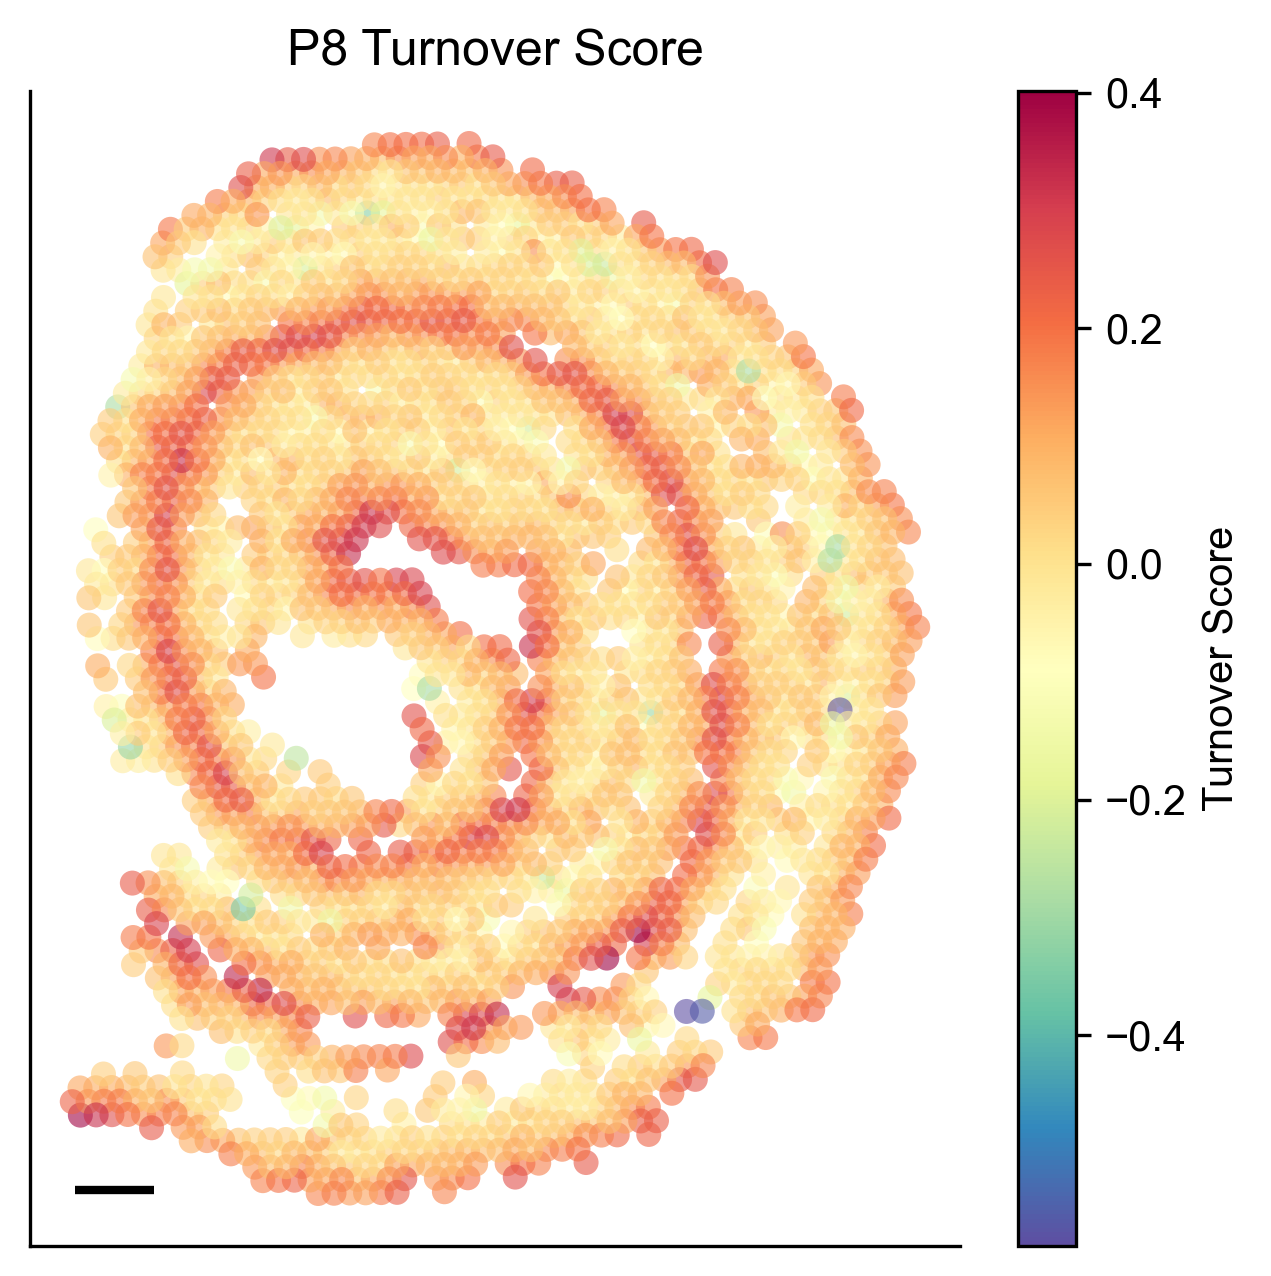

In [8]:
pt_name = "P8"
df = yotam_visium[pt_name]
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
scatter = sns.scatterplot(data=df.obs, x='x', y='y', hue='shedding_score', alpha=0.6, edgecolor=None, linewidth=0, palette="Spectral_r")

scatter.legend_.remove()

# Add a colorbar
norm = plt.Normalize(df.obs['shedding_score'].min(), df.obs['shedding_score'].max())
sm = plt.cm.ScalarMappable(cmap="Spectral_r", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Turnover Score')


# hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# hide x and y labels
ax.set_xlabel('')
ax.set_ylabel('')

# hide x and y ticks
ax.set_xticks([])
ax.set_yticks([])


size_100um = df.uns['size_100um']
scalebar_x = df.obs.x.min() + 5
scalebar_y = df.obs.y.min() + 5
plt.plot([scalebar_x, scalebar_x + size_100um*5], [scalebar_y, scalebar_y], color='black', lw=2, solid_capstyle='butt')

plt.title(pt_name + " Turnover Score")
plt.show()
fig.savefig(figure_path+"edf2b_turnover"+pt_name+".pdf", bbox_inches='tight')

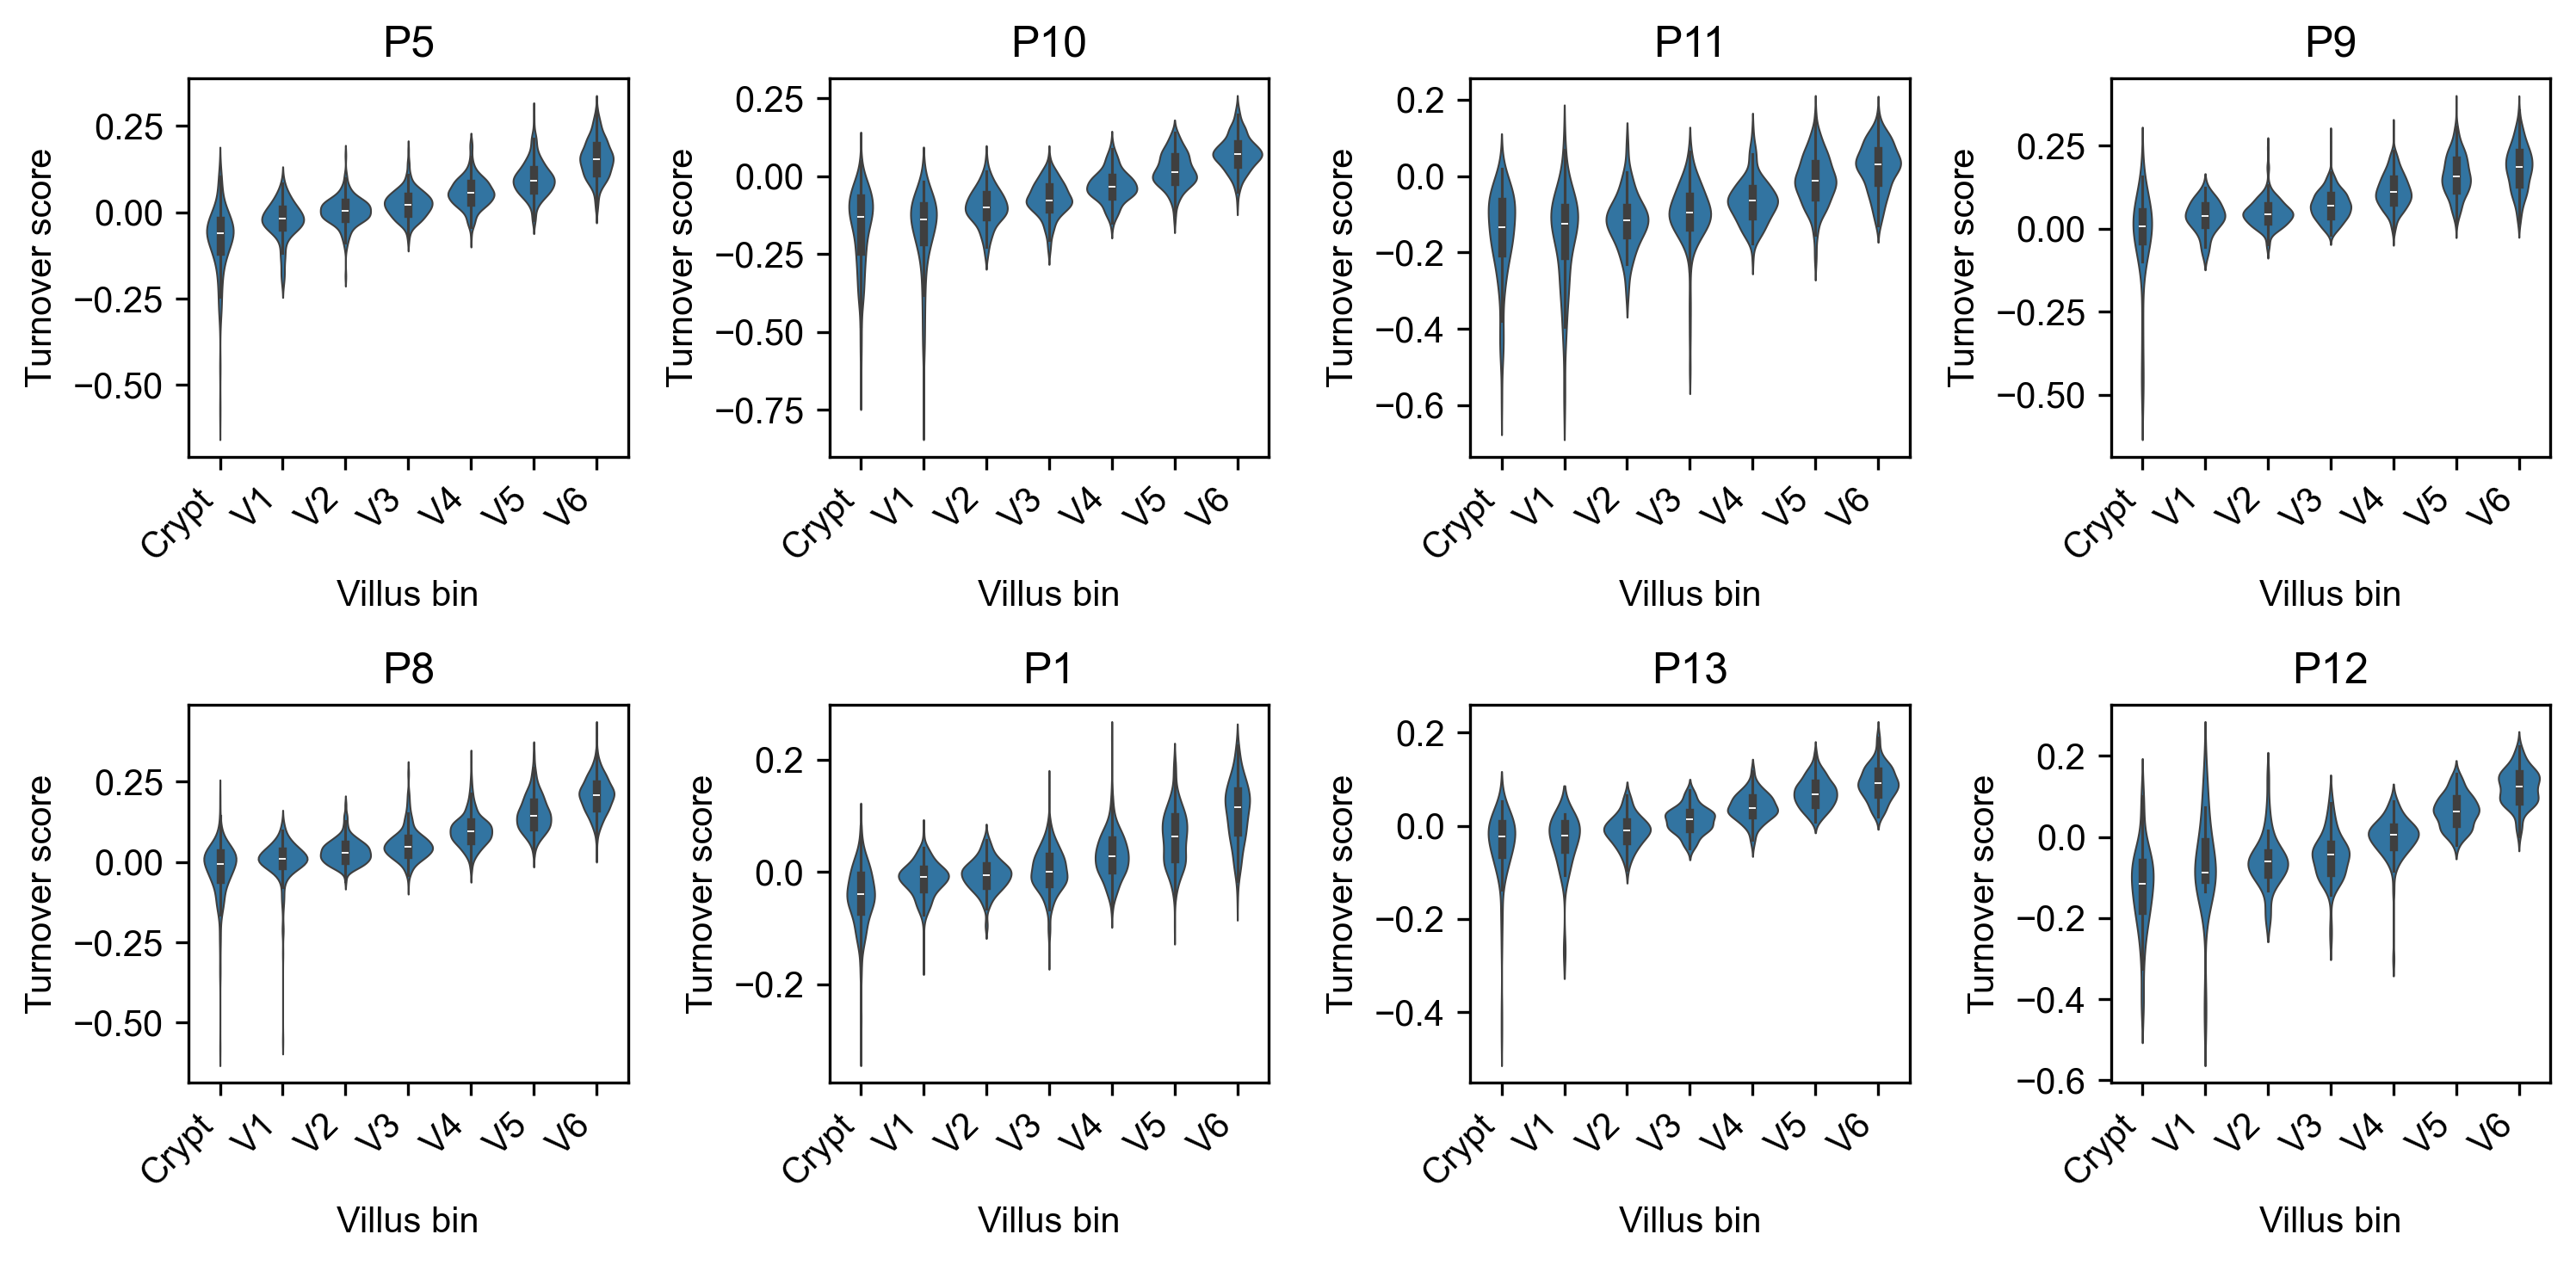

In [9]:
# Calculate the number of rows and columns needed for a square layout
num_plots = len(yotam_visium.keys())
num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5), dpi=300)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for ax, key in zip(axes, yotam_visium.keys()):
    sns.violinplot(data=yotam_visium[key].obs, x='villus_bin', y='shedding_score', order=["Crypt","V1","V2","V3","V4","V5","V6"], ax=ax, linewidth=0.5)
    ax.set_title(key)

# Hide any unused subplots
for ax in axes[num_plots:]:
    ax.set_visible(False)

# ylabel
for ax in axes:
    ax.set_ylabel('Turnover score')
    ax.set_xlabel('Villus bin')
    # xlabel rotation
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')

plt.tight_layout()
plt.show()
# fig.savefig(figure_path+"edf2b_yotam_shedding_violins.pdf", bbox_inches='tight')

/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1036926167.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_shedding_scores[key] = yotam_visium[key].obs.groupby('villus_bin')['shedding_score'].median()
/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1036926167.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_shedding_scores[key] = yotam_visium[key].obs.groupby('villus_bin')['shedding_score'].median()
/var/folders/12/7sg1l7495mg7m46t8zdt5pzm0000gn/T/ipykernel_31154/1036926167.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to 

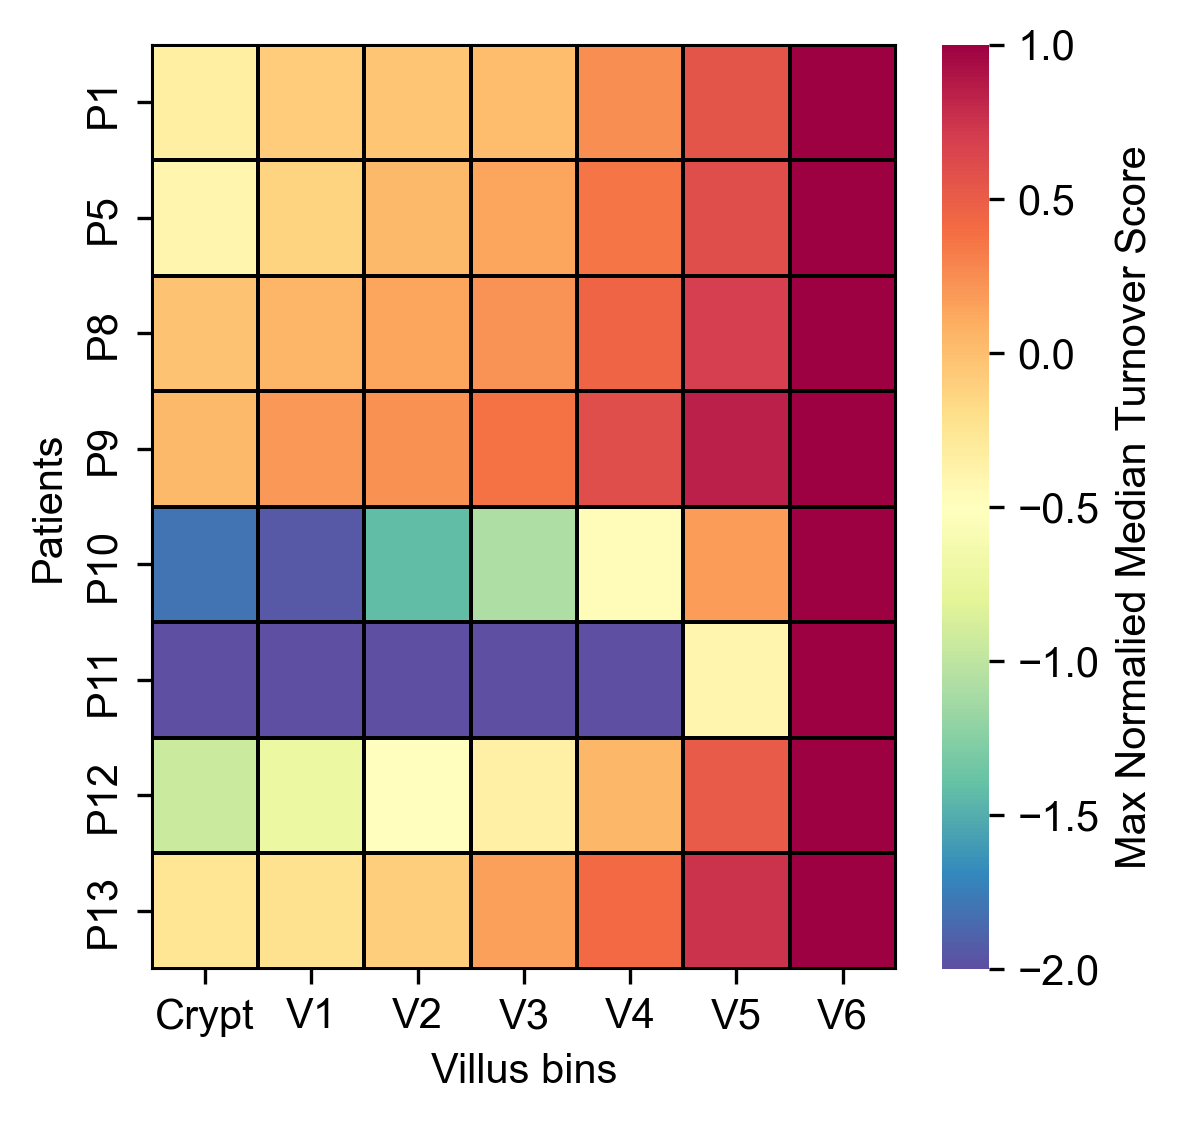

In [10]:
# create a dataframe where each row is a patient and each columns is a villus bin
# the values are the shedding score for each patient in each villus bin
bin_shedding_scores = pd.DataFrame()
for key in yotam_visium.keys():
    bin_shedding_scores[key] = yotam_visium[key].obs.groupby('villus_bin')['shedding_score'].median()

bin_shedding_scores.drop(["MusMucosa","SubMucosa"], inplace=True)
bin_shedding_scores = bin_shedding_scores.T
bin_shedding_scores = bin_shedding_scores.reindex(sorted(bin_shedding_scores.index, key=lambda x: int(x[1:])))

# max normalize each row
bin_shedding_scores = bin_shedding_scores.div(bin_shedding_scores.max(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sns.heatmap(bin_shedding_scores, cmap='Spectral_r', linewidths=0.5, linecolor='black',
             vmin=-2,cbar_kws={'label': 'Max Normalied Median Turnover Score'})
plt.ylabel("Patients")
plt.xlabel("Villus bins")

# Add line to the outer frame
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)
plt.show()
fig.savefig(figure_path+"edf2c_yotam_shedding_summary.pdf", bbox_inches='tight')

In [11]:
print(datetime.now())

2025-07-17 08:25:54.196538
